# ***Scandinavian News Articles***

This notebook is a part of the final project in *Computational Tools for data science 02807*

### ***Imports***

In [38]:
import pandas as pd 
from IPython.display import display, HTML

### ***Import Dataset***

The datasets have been scraped using Selenium and BeautifulSoup.

In [39]:
news_articles = pd.read_csv('data/articles.csv')

# information about the dataset
news_articles.shape[0]
news_articles.info()
news_articles.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192 entries, 0 to 1191
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             1192 non-null   object
 1   headline         1192 non-null   object
 2   content          1192 non-null   object
 3   url              1192 non-null   object
 4   source           1192 non-null   object
 5   country          1192 non-null   object
 6   worldview_score  1192 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 65.3+ KB


,date,headline,content,url,source,country,worldview_score
0,2024-04-10,Skakande orden i rätten: ”Rann blod i mina ögon”,Under 30 minuter misshandlade de tre män och h...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3
1,2021-03-30,Trumps vändning: Blir inga matkuponger,Det blir inga utbetalningar av matkuponger för...,https://www.aftonbladet.se/nyheter/a/GyvQb9/tr...,Aftonbladet,sweden,3
2,2021-01-27,Skakande orden i rätten: ”Rann blod i mina ögon”,/ Under 30 minuter misshandlade de tre män och...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3
3,2025-09-23,"Trump drømmer om fredspris, men siden torsdag ...","Trump har både harceleret mod ""Forever Wars"" o...",https://www.dr.dk/nyheder/udland/trump-droemme...,DR,denmark,3
4,2024-07-05,Kina forbyder influencere at dele sundhedstips...,Intentionen med loven er at forhindre sprednin...,https://www.dr.dk/nyheder/udland/kina-forbyder...,DR,denmark,3


### ***Preprocessing Steps***

#### 1. Clean content 

In [40]:
import re
import pandas as pd

# 1) Define "boilerplate" markers you want to cut away and everything after
SUBSCRIPTION_MARKERS = [
    "Allerede abonnent? Log ind",
    "Allerede abonnent? Log ind her",
    "Log ind for at læse",
    "Log ind for at læse hele artiklen",
    "Log ind for at læse videre",
    "Logg inn for å lese",
    "Bli abonnent",
    "Tegn abonnement",
    "Få adgang til hele artiklen",
    "Få adgang til alt indhold",

    # Swedish / Norwegian / Danish "read more" prompts
    "Läs mer",       # SE
    "Læs mere",      # DK
    "Les mer",       # NO

    # DN print-view header
    "En utskrift från Dagens Nyheter",
]

def clean_content(text: str) -> str:
    if pd.isna(text):
        return ""
    t = str(text)

    # --- basic formatting fixes ---
    # remove leading "/ " like "/ Under 30 minuter ..."
    t = re.sub(r'^\s*/\s*', '', t)

    # remove bullet characters that often appear in scraped content
    t = t.replace("•", " ")

    # --- cut off subscription / boilerplate tail ---
    lower = t.lower()
    cut_pos = len(t)
    for marker in SUBSCRIPTION_MARKERS:
        idx = lower.find(marker.lower())
        if idx != -1 and idx < cut_pos:
            cut_pos = idx

    t = t[:cut_pos]

    # --- normalize whitespace ---
    t = re.sub(r'\s+', ' ', t).strip()

    return t

# Apply to your dataframe
news_articles['content_clean'] = news_articles['content'].apply(clean_content)

news_articles.head(5)

,date,headline,content,url,source,country,worldview_score,content_clean
0,2024-04-10,Skakande orden i rätten: ”Rann blod i mina ögon”,Under 30 minuter misshandlade de tre män och h...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3,Under 30 minuter misshandlade de tre män och h...
1,2021-03-30,Trumps vändning: Blir inga matkuponger,Det blir inga utbetalningar av matkuponger för...,https://www.aftonbladet.se/nyheter/a/GyvQb9/tr...,Aftonbladet,sweden,3,Det blir inga utbetalningar av matkuponger för...
2,2021-01-27,Skakande orden i rätten: ”Rann blod i mina ögon”,/ Under 30 minuter misshandlade de tre män och...,https://www.aftonbladet.se/nyheter/a/OoLd3k/na...,Aftonbladet,sweden,3,Under 30 minuter misshandlade de tre män och h...
3,2025-09-23,"Trump drømmer om fredspris, men siden torsdag ...","Trump har både harceleret mod ""Forever Wars"" o...",https://www.dr.dk/nyheder/udland/trump-droemme...,DR,denmark,3,"Trump har både harceleret mod ""Forever Wars"" o..."
4,2024-07-05,Kina forbyder influencere at dele sundhedstips...,Intentionen med loven er at forhindre sprednin...,https://www.dr.dk/nyheder/udland/kina-forbyder...,DR,denmark,3,Intentionen med loven er at forhindre sprednin...


#### 1. Remove irrelevant links

In some norwegian articles posted by "vg.no" there are links to another website called "e24.no". These are not relevant for the project, and are therefore dropped from the data frame

In [41]:
# drop all norwegian articles from "vg" that contains "e24" in the url
e24_links = news_articles[(news_articles['country'] == 'norway') & (news_articles['source'] == 'vg') & (news_articles['url'].str.contains('https://e24.no'))]
news_articles = news_articles.drop(e24_links.index)
news_articles.reset_index(drop=True, inplace=True)

# print number of articles after preprocessing
print("Number of articles after preprocessing:", news_articles.shape[0])

Number of articles after preprocessing: 1184


#### 2. Remove invalid source

During scraping the source "news" has been included, which is not a valid source. Rows with this source has also been dropped. 

In [42]:
# count rows with source "news"
invalid_source = news_articles[news_articles['source'] == 'news']
print("Number of articles with source 'news':", invalid_source.shape[0])

# drop rows with source "news"
news_articles = news_articles[news_articles['source'] != 'news']
news_articles.reset_index(drop=True, inplace=True)
print("Number of articles after dropping 'news' source:", news_articles.shape[0])

Number of articles with source 'news': 9
Number of articles after dropping 'news' source: 1175


#### 3. Standardize source names

Some sources have uppercase letters and some not, so we standardize by only using lowercase.

In [43]:
news_articles['source'] = news_articles['source'].str.lower()

#### 4. Remove articles outside the intended time period 2020-2025

In [44]:
news_articles['date'] = pd.to_datetime(news_articles['date'], errors='coerce')
news_articles = news_articles[(news_articles['date'] >= '2020-01-01') & (news_articles['date'] <= '2025-12-31')]
news_articles.reset_index(drop=True, inplace=True)
print("Number of articles after removing those outside 2020-2025:", news_articles.shape[0])

Number of articles after removing those outside 2020-2025: 1172


#### 5. Remove duplicates

In [45]:
# 1. Drop strict duplicates (same URL + same content + same headline)
news_articles = news_articles.drop_duplicates(
    subset=['url', 'source', 'content_clean', 'headline']
).reset_index(drop=True)

print("After strict duplicates:", news_articles.shape[0])

# 2. Drop soft duplicates (same content/headline but different URL)
news_articles = news_articles.drop_duplicates(
    subset=['content_clean', 'headline']
).reset_index(drop=True)

print("After soft duplicates:", news_articles.shape[0])

After strict duplicates: 1090
After soft duplicates: 1042


#### 6. Drop articles with worldview score 6, i.e., not classified

In [46]:
news_articles = news_articles[news_articles['worldview_score'] != 6]
news_articles.reset_index(drop=True, inplace=True)
print("Number of articles after dropping unclassified worldview score:", news_articles.shape[0])

Number of articles after dropping unclassified worldview score: 592


### ***Dataset Exploration***

#### Source information

The table below presents information about the sources we have retrieved. 

In [47]:
unique_sources = news_articles[['country', 'source']].drop_duplicates().sort_values(by='country')

sources_per_country = unique_sources['country'].value_counts()
display(HTML("<h4 style='font-weight:700'>Number of Sources per Country:</h4>"))
display(HTML("<pre style='font-family:monospace'>{}</pre>".format(
    sources_per_country.rename(index=lambda s: s.capitalize()).to_string(header=False)
)))

src_counts = (news_articles
              .groupby(['country', 'source'])
              .size()
              .reset_index(name='n_articles'))

# compute average worldview_score per country and source
temp_view = news_articles.copy()
temp_view['worldview_num'] = pd.to_numeric(temp_view['worldview_score'], errors='coerce')
avg_world = temp_view.groupby(['country', 'source'])['worldview_num'].mean().reset_index(name='avg_worldview').round(2)
display_df = src_counts.merge(avg_world, on=['country', 'source'], how='left')

# add column showing the time range of articles per country and source
time_ranges = (news_articles
                .groupby(['country', 'source'])
                .agg(first_article=('date', 'min'), last_article=('date', 'max'))
                .reset_index())

time_ranges['time_range'] = (
    time_ranges['first_article'].dt.strftime('%Y-%m-%d') +
    ' to ' +
    time_ranges['last_article'].dt.strftime('%Y-%m-%d')
)

display_df = display_df.merge(time_ranges[['country', 'source', 'time_range']], on=['country', 'source'])  
display_df = display_df[['source', 'n_articles', 'avg_worldview', 'country', 'time_range']]
display_df = display_df.sort_values(by='country').copy()
display(HTML(display_df.to_html(index=False, border=0)))

source,n_articles,avg_worldview,country,time_range
berlingske,96,2.32,denmark,2020-11-11 to 2025-10-29
dr,172,2.53,denmark,2020-11-15 to 2025-10-23
information,38,3.00,denmark,2020-12-04 to 2025-10-24
jyllands-posten,98,2.39,denmark,2020-11-19 to 2025-10-10
politiken,2,3.00,denmark,2021-12-02 to 2024-02-18
aftenposten,2,3.00,norway,2021-04-30 to 2024-08-24
dagbladet,2,4.00,norway,2020-11-08 to 2024-01-23
nrk,35,2.57,norway,2020-11-30 to 2025-06-28
vg,41,2.46,norway,2021-01-09 to 2025-11-05
aftonbladet,25,2.68,sweden,2021-03-30 to 2025-09-03


#### Article Distribution

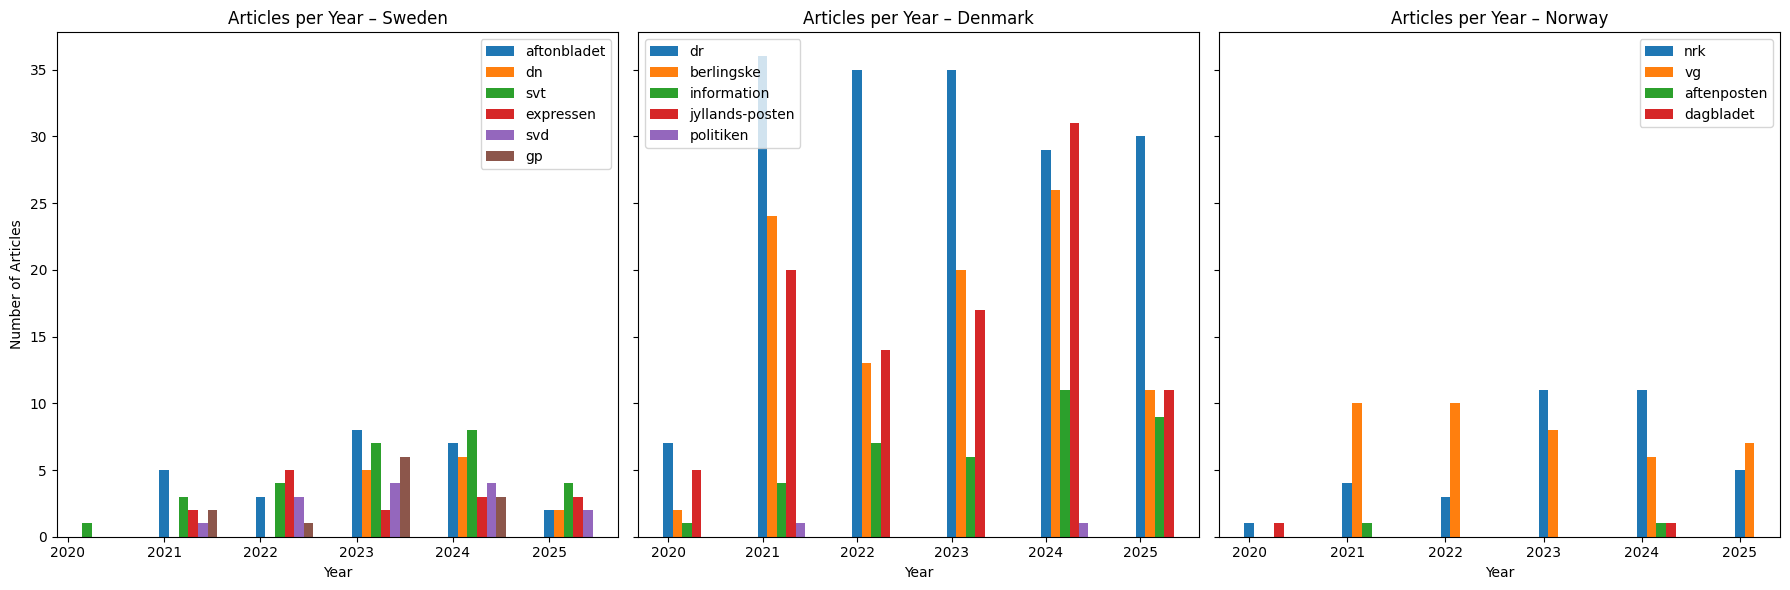

In [48]:
import matplotlib.pyplot as plt

countries = news_articles['country'].unique()
num_countries = len(countries)

fig, axes = plt.subplots(1, num_countries, figsize=(18, 6), sharey=True)

if num_countries == 1:
    axes = [axes]

for ax, country in zip(axes, countries):
    country_data = news_articles[news_articles['country'] == country].copy()

    for i, source in enumerate(country_data['source'].unique()):
        source_data = country_data[country_data['source'] == source].copy()
        source_data['year'] = source_data['date'].dt.year
        year_counts = source_data['year'].value_counts().sort_index()

        ax.bar(
            year_counts.index + (0.1 * i),
            year_counts.values,
            width=0.1,
            label=source
        )

    ax.set_title(f'Articles per Year – {country.capitalize()}')
    ax.set_xlabel('Year')
    ax.set_xticks(range(2020, 2026))
    ax.legend()

axes[0].set_ylabel('Number of Articles')

plt.tight_layout()
plt.show()

#### Average Worldview in each Country from 2020-2025

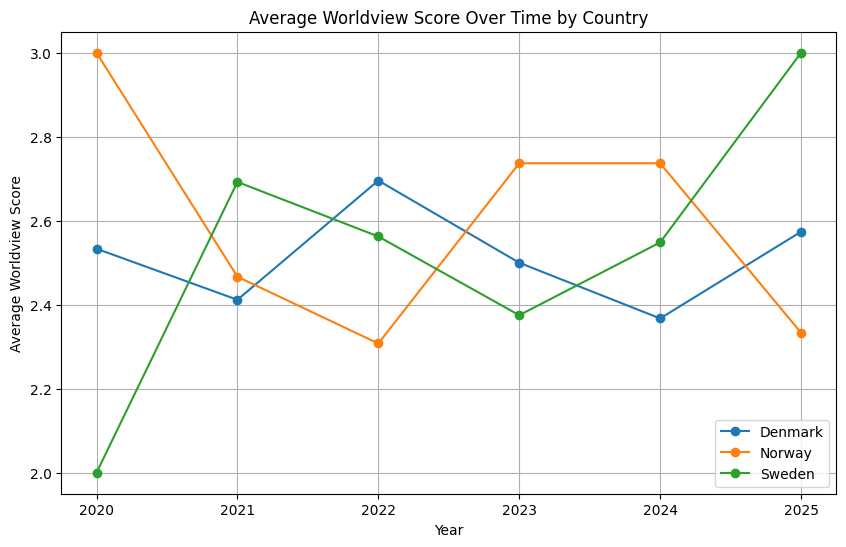

In [49]:
import matplotlib.pyplot as plt
worldview_over_time = (news_articles
                       .copy())
worldview_over_time['worldview_num'] = pd.to_numeric(worldview_over_time['worldview_score'], errors='coerce')
worldview_over_time['year'] = worldview_over_time['date'].dt.year
avg_worldview_time = (worldview_over_time
                      .groupby(['country', 'year'])['worldview_num']
                      .mean()
                      .reset_index())

plt.figure(figsize=(10, 6))
for country in avg_worldview_time['country'].unique():
    country_data = avg_worldview_time[avg_worldview_time['country'] == country]
    plt.plot(country_data['year'], country_data['worldview_num'], marker='o', label=country.capitalize())

    
plt.title('Average Worldview Score Over Time by Country')
plt.xlabel('Year')
plt.ylabel('Average Worldview Score')
plt.xticks(avg_worldview_time['year'].unique())
plt.legend()
plt.grid()
plt.show()

### ***TF-IDF***

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

base_stopwords = set(stopwords.words('english') +
                       stopwords.words('swedish') +
                       stopwords.words('danish') +
                       stopwords.words('norwegian'))

# Domain-specific extra stopwords: outlets, generic news words, light verbs/adverbs
extra_stopwords = {
    "vg", "nrk", "aftonbladet", "dr", "artikler", "artikkel", "artikel",
    "sier", "mener", "siste", "litt", "mye", "mer", "år", "dag", "dager",
    "blant", "andre", "må", "fikk", "veldig", "annet", "går", "nå",
    "uten", "over", "etter", "inn", "to", "via", "se", "gå", "kom", "kommet",
    "ifølge", "har", "ha", "være", "viktig", "nyhet", "nyheter", "les", "lese",
    # add more as you notice junk terms
}

custom_stopwords = list(base_stopwords.union(extra_stopwords))

vectorizer = TfidfVectorizer(
    stop_words=custom_stopwords,   # must be list, not set
    max_features=5000,
    ngram_range=(1, 2)
)

news_articles['text'] = news_articles['headline'].fillna('') + " " + news_articles['content'].fillna('')
tfidf_matrix = vectorizer.fit_transform(news_articles['text'])

feature_names = vectorizer.get_feature_names_out()


print("TF-IDF shape:", tfidf_matrix.shape)

TF-IDF shape: (592, 5000)


[nltk_data] Downloading package stopwords to /home/Felix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
def top_tfidf_terms(mask, n=30):
    sub = tfidf_matrix[mask.values]  # Convert pandas Series to numpy array
    mean_scores = sub.mean(axis=0).A1
    top_idx = mean_scores.argsort()[::-1][:n]
    return [(feature_names[i], mean_scores[i]) for i in top_idx]

# Example: top terms for Sweden
sweden_mask = news_articles['country'] == 'sweden'
top_tfidf_terms(sweden_mask)

[('ska', np.float64(0.05869392080915847)),
 ('säger', np.float64(0.0553529702253139)),
 ('new', np.float64(0.03182091406572025)),
 ('flera', np.float64(0.03128408506696325)),
 ('enligt', np.float64(0.029327154419352325)),
 ('mamdani', np.float64(0.02818219927508382)),
 ('nya', np.float64(0.02585757438957665)),
 ('mån', np.float64(0.024232152073983056)),
 ('också', np.float64(0.02373168870033235)),
 ('kr', np.float64(0.02251457022603875)),
 ('new york', np.float64(0.020485947259645067)),
 ('vill', np.float64(0.020418337892009215)),
 ('york', np.float64(0.02022467238308957)),
 ('zohran', np.float64(0.019936550800335406)),
 ('polisen', np.float64(0.019743970837758903)),
 ('första', np.float64(0.01956868797210265)),
 ('svt', np.float64(0.01933450819124053)),
 ('kr mån', np.float64(0.017858501894322348)),
 ('läs', np.float64(0.01772870002001105)),
 ('dn', np.float64(0.0176623325262432)),
 ('vet', np.float64(0.01746779710963626)),
 ('zohran mamdani', np.float64(0.017456180592679813)),
 ('kri

### ***Test some LSH***

In [52]:
import re
import pandas as pd

# If not already there: combine headline + content
news_articles['combined'] = news_articles['headline'].fillna('') + ' ' + news_articles['content'].fillna('')

def get_shingles(text, k=5):
    """
    Create word shingles (k-grams) from a text.
    Example: k=5 means sequences of 5 consecutive words.
    """
    # basic tokenization: keep alphanumeric words
    tokens = re.findall(r'\w+', str(text).lower())
    if len(tokens) < k:
        return set([' '.join(tokens)]) if tokens else set()
    return {
        ' '.join(tokens[i:i + k])
        for i in range(len(tokens) - k + 1)
    }

# Quick test on one article:
example_shingles = get_shingles(news_articles['combined'].iloc[3], k=5)
len(example_shingles), list(example_shingles)[:5]

(325,
 ['reklamere for medicin og kosttilskud',
  'og økonomi lyder den officielle',
  'eventuelle forbehold men udover bekæmpelse',
  'været nogle uheldige eksempler i',
  'er at forhindre spredning af'])

In [53]:
from datasketch import MinHash

def create_minhash(shingles, num_perm=128):
    """
    Build a MinHash signature from a set of shingles.
    num_perm controls the signature size (and accuracy).
    """
    m = MinHash(num_perm=num_perm)
    for sh in shingles:
        m.update(sh.encode('utf-8'))
    return m

num_perm = 128
k = 5  # shingle size

minhashes = {}

for idx, text in news_articles['text'].items():
    shingles = get_shingles(text, k=k)
    m = create_minhash(shingles, num_perm=num_perm)
    minhashes[idx] = m

len(minhashes)

592

In [54]:
from datasketch import MinHashLSH

# threshold ≈ Jaccard similarity threshold
lsh_threshold = 0.5  # try 0.5–0.8 depending on how strict you want it

lsh = MinHashLSH(threshold=lsh_threshold, num_perm=num_perm)

for idx, m in minhashes.items():
    # keys must be hashable; we'll use string of index
    lsh.insert(str(idx), m)

In [55]:
import numpy as np

similar_pairs = set()  # to avoid duplicates like (3, 5) and (5, 3)

for i, m in minhashes.items():
    neighbors = lsh.query(m)
    for j in neighbors:
        j = int(j)
        if j == i:
            continue
        pair = tuple(sorted((i, j)))
        similar_pairs.add(pair)

len(similar_pairs)

7

In [56]:
results = []

for i, j in similar_pairs:
    sim_est = minhashes[i].jaccard(minhashes[j])  # approx Jaccard
    results.append((sim_est, i, j))

# Sort by similarity (highest first)
results.sort(reverse=True, key=lambda x: x[0])

# Show top N similar pairs
N = 20
for sim, i, j in results[:N]:
    print(f"\nPair: {i} – {j} | est. Jaccard: {sim:.3f}")
    print("A:", news_articles.loc[i, 'headline'])
    print("B:", news_articles.loc[j, 'headline'])
    print("Sources:", news_articles.loc[i, 'source'], "|", news_articles.loc[j, 'source'])
    print("Countries:", news_articles.loc[i, 'country'], "|", news_articles.loc[j, 'country'])


Pair: 274 – 380 | est. Jaccard: 1.000
A: AaB vil sikre likviditet til strategi med kapitaludvidelse
B: AaB vil sikre likviditet til strategi med kapitaludvidelse
Sources: jyllands-posten | berlingske
Countries: denmark | denmark

Pair: 67 – 74 | est. Jaccard: 0.805
A: Ansøgninger fra Bangladesh og Nepal til uddannelser falder efter stramninger
B: Ansøgninger fra Bangladesh og Nepal til uddannelser falder efter stramninger
Sources: dr | jyllands-posten
Countries: denmark | denmark

Pair: 268 – 273 | est. Jaccard: 0.656
A: Politi anholder mand i Risskov mistænkt i sag om angrebsplan i Tyskland
B: Politi anholder mand i Risskov mistænkt i spionagesag i Tyskland
Sources: berlingske | jyllands-posten
Countries: denmark | denmark

Pair: 159 – 188 | est. Jaccard: 0.461
A: Stor insats på Stegra – flera enheter på plats0:25
B: Stor insats på Stegra – flera enheter på plats0:25
Sources: aftonbladet | aftonbladet
Countries: sweden | sweden

Pair: 150 – 189 | est. Jaccard: 0.430
A: Akut säkerhets

In [57]:
# print details of pair 146 and 468
i, j = 146, 468
print(f"\nPair: {i} – {j} | est. Jaccard: {minhashes[i].jaccard(minhashes[j]):.3f}")
print("A:", news_articles.loc[i, 'headline'])
print("B:", news_articles.loc[j, 'headline'])
print("Sources:", news_articles.loc[i, 'source'], "|", news_articles.loc[j, 'source'])
print("Countries:", news_articles.loc[i, 'country'], "|", news_articles.loc[j, 'country'])
print("Content" 
      ,"\nA:", news_articles.loc[i, 'content_clean'][:200], "...\nB:", news_articles.loc[j, 'content_clean'][:200], "...")
print("url", news_articles.loc[i, 'url'], "|", news_articles.loc[j, 'url'])


Pair: 146 – 468 | est. Jaccard: 0.281
A: Expert: Fick kämpa hårt för urvattnad kompromiss
B: Expert: Fick kämpa hårt för urvattnad kompromiss
Sources: aftonbladet | svd
Countries: sweden | sweden
Content 
A: TT chevron-right Publicerad 12.06 EU-ländernas beslut om nya klimatmål blev en urvattnad kompromiss, anser klimatforskaren Naghmeh Nasiritousi. – Men det är ändå ett viktigt steg för att EU ska ha någ ...
B: EU-ländernas beslut om nya klimatmål blev en urvattnad kompromiss, anser klimatforskaren Naghmeh Nasiritousi. – Men det är ändå ett viktigt steg för att EU ska ha någon sorts trovärdighet på klimatmöt ...
url https://www.aftonbladet.se/nyheter/a/JbPblP/expert-fick-kampa-hart-for-urvattnad-kompromiss | https://www.svd.se/a/zARA85/expert-fick-kampa-hart-for-urvattnad-kompromiss


In [58]:
# print details of pair 159 and 188
i, j = 159, 188
print(f"\nPair: {i} – {j} | est. Jaccard: {minhashes[i].jaccard(minhashes[j]):.3f}")
print("A:", news_articles.loc[i, 'headline'])
print("B:", news_articles.loc[j, 'headline'])
print("Sources:", news_articles.loc[i, 'source'], "|", news_articles.loc[j, 'source'])
print("Countries:", news_articles.loc[i, 'country'], "|", news_articles.loc[j, 'country'])
print("Content" 
      ,"\nA:", news_articles.loc[i, 'content_clean'][:200], "...\nB:", news_articles.loc[j, 'content_clean'][:200], "...")
print("url", news_articles.loc[i, 'url'], "|", news_articles.loc[j, 'url'])


Pair: 159 – 188 | est. Jaccard: 0.461
A: Stor insats på Stegra – flera enheter på plats0:25
B: Stor insats på Stegra – flera enheter på plats0:25
Sources: aftonbladet | aftonbladet
Countries: sweden | sweden
Content 
A: arrow Aftonbladets app checkSnabbare checkMindre reklam checkBara de pushnotiser du vill Ett svårt skadat får hittades i januari i närheten av ett lantbruksgymnasium i Värmland. Det visade sig att en  ...
B: arrow Aftonbladets app checkSnabbare checkMindre reklam checkBara de pushnotiser du vill Tio personer har blivit påkörda av en bil på ön Île d'Oléron, skriver franska medier. Fem personer har skadats  ...
url https://www.aftonbladet.se/nyheter/a/Rr77qd/aftonbladet-direkt?pinnedEntry=1421005 | https://www.aftonbladet.se/nyheter/a/Rr77qd/aftonbladet-direkt?pinnedEntry=1421008


In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
import pandas as pd

docs = news_articles['content'].astype(str).tolist()

vect = CountVectorizer(analyzer='char', ngram_range=(5,5), binary=True)
X = vect.fit_transform(docs)

# Compute pairwise Jaccard distances (1 - similarity)
distances = pdist(X.toarray(), metric="jaccard")

# Convert to a matrix
dist_matrix = squareform(distances)

# Convert to similarity:
sim_matrix = 1 - dist_matrix

# You MUST pass metric="precomputed" since you're giving distances
db = DBSCAN(
    eps=0.905,       # important: tune this
    min_samples=7, # also tunable
    metric='precomputed'
)

labels = db.fit_predict(dist_matrix)

cluster_counts = pd.Series(labels).value_counts().sort_index()
print(cluster_counts)

-1    363
 0    161
 1      8
 2     14
 3     33
 4     13
Name: count, dtype: int64


### ***Approximate Nearest Neighbor (ANN)***

In [60]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def build_ann_index(matrix, n_neighbors=10, metric='cosine'):
    """
    Build an ANN index using scikit-learn's NearestNeighbors.
    Works with TF-IDF or any sparse matrix.
    """
    nn = NearestNeighbors(
        n_neighbors=n_neighbors + 1,  
        metric=metric,
        algorithm='brute'  # sparse matrices
    )
    nn.fit(matrix)
    return nn

def find_similar_articles(query_idx, ann_index, matrix, n_neighbors=10):
    """
    Find most similar articles to a given article using ANN.
    Returns indices and distances of similar articles.
    """
    query_vector = matrix[query_idx:query_idx+1]
    distances, indices = ann_index.kneighbors(query_vector)
    
    # Remove the query article itself (first result)
    return indices[0][1:], distances[0][1:]

# Build ANN index on TF-IDF matrix
ann_index = build_ann_index(tfidf_matrix, n_neighbors=10)

# Test: find articles similar to article 0
similar_indices, distances = find_similar_articles(5, ann_index, tfidf_matrix, n_neighbors=10)

print(f"Articles similar to article 5: '{news_articles.loc[5, 'headline']}'")
print(f"Source: {news_articles.loc[5, 'source']} | Country: {news_articles.loc[5, 'country']}\n")

for idx, dist in zip(similar_indices, distances):
    similarity = 1 - dist  # convert distance to similarity
    print(f"Similarity: {similarity:.3f} | Article {idx}")
    print(f"Headline: {news_articles.loc[idx, 'headline']}")
    print(f"Source: {news_articles.loc[idx, 'source']} | Country: {news_articles.loc[idx, 'country']}\n")

Articles similar to article 5: 'Imamer mægler i voldssager og saboterer politiets arbejde'
Source: berlingske | Country: denmark

Similarity: 0.125 | Article 578
Headline: Berlingske mener: Vores retsstat gælder for alle – også klimaaktivister
Source: berlingske | Country: denmark

Similarity: 0.122 | Article 227
Headline: Politiet: Psykisk syge skal ikke mødes af politiuniformer
Source: dr | Country: denmark

Similarity: 0.108 | Article 524
Headline: I flere år har politiet tvunget tøjet af anholdte uden konkret mistanke: »Det er klart ulovligt«
Source: berlingske | Country: denmark

Similarity: 0.101 | Article 273
Headline: Politi anholder mand i Risskov mistænkt i spionagesag i Tyskland
Source: jyllands-posten | Country: denmark

Similarity: 0.090 | Article 531
Headline: Københavns Politi »skal ikke i underbukserne på alle«. Alligevel har betjente forklaret, at det er »normal procedure«
Source: berlingske | Country: denmark

Similarity: 0.085 | Article 268
Headline: Politi anholder 

#### ANN Analysis by Country and Worldview

In [61]:
def analyze_similarities_by_country(ann_index, matrix, news_df, n_neighbors=10):
    """
    Analyze how similar articles cluster by country and worldview.
    """
    country_similarities = []
    worldview_similarities = []
    
    for i in range(len(news_df)):
        similar_indices, distances = find_similar_articles(i, ann_index, matrix, n_neighbors)
        
        query_country = news_df.loc[i, 'country']
        query_worldview = news_df.loc[i, 'worldview_score']
        
        # Count same-country neighbors
        same_country = sum(1 for idx in similar_indices 
                          if news_df.loc[idx, 'country'] == query_country)
        country_similarities.append(same_country / len(similar_indices))
        
        # Count same-worldview neighbors
        same_worldview = sum(1 for idx in similar_indices 
                           if news_df.loc[idx, 'worldview_score'] == query_worldview)
        worldview_similarities.append(same_worldview / len(similar_indices))
    
    return country_similarities, worldview_similarities

country_sim, worldview_sim = analyze_similarities_by_country(ann_index, tfidf_matrix, news_articles)

print(f"Average same-country similarity ratio: {np.mean(country_sim):.3f}")
print(f"Average same-worldview similarity ratio: {np.mean(worldview_sim):.3f}")

# Breakdown by country
country_breakdown = news_articles.copy()
country_breakdown['country_sim_ratio'] = country_sim
country_breakdown['worldview_sim_ratio'] = worldview_sim

country_stats = (country_breakdown
                .groupby('country')
                .agg({
                    'country_sim_ratio': 'mean',
                    'worldview_sim_ratio': 'mean'
                })
                .round(3))

display(HTML("<h4>Similarity Analysis by Country</h4>"))
display(HTML(country_stats.to_html()))

Average same-country similarity ratio: 0.856
Average same-worldview similarity ratio: 0.660


,country_sim_ratio,worldview_sim_ratio
country,,
denmark,0.929,0.662
norway,0.539,0.628
sweden,0.813,0.677


### ***DBSCAN Clustering***

In [62]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt

def perform_dbscan_clustering(matrix, eps=0.3, min_samples=5, metric='cosine'):
    """
    Perform DBSCAN clustering on the feature matrix.
    For cosine metric, we compute distances and use precomputed.
    """
    if metric == 'cosine':
        # Convert sparse matrix to dense for cosine distance calculation
        dense_matrix = matrix.toarray() if hasattr(matrix, 'toarray') else matrix
        distance_matrix = cosine_distances(dense_matrix)
        
        dbscan = DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric='precomputed'
        )
        labels = dbscan.fit_predict(distance_matrix)
    else:
        dbscan = DBSCAN(
            eps=eps,
            min_samples=min_samples,
            metric=metric
        )
        labels = dbscan.fit_predict(matrix.toarray() if hasattr(matrix, 'toarray') else matrix)
    
    return labels

def analyze_clusters(labels, news_df):
    """
    Analyze the clustering results.
    """
    cluster_df = news_df.copy()
    cluster_df['cluster'] = labels
    
    # Count clusters
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    n_clusters = len(cluster_counts[cluster_counts.index != -1])
    n_noise = cluster_counts.get(-1, 0)
    
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    print(f"Clustering ratio: {(len(labels) - n_noise) / len(labels):.3f}")
    
    return cluster_df, cluster_counts

# Test different eps values
eps_values = [0.2, 0.3, 0.4, 0.5]
clustering_results = {}

for eps in eps_values:
    labels = perform_dbscan_clustering(tfidf_matrix, eps=eps, min_samples=3)
    cluster_df, cluster_counts = analyze_clusters(labels, news_articles)
    clustering_results[eps] = (labels, cluster_df, cluster_counts)
    
    print(f"\nEps={eps}:")
    n_clusters = len(cluster_counts[cluster_counts.index != -1])
    n_noise = cluster_counts.get(-1, 0)
    print(f"  Clusters: {n_clusters}, Noise: {n_noise}")

Number of clusters: 2
Number of noise points: 583
Clustering ratio: 0.015

Eps=0.2:
  Clusters: 2, Noise: 583
Number of clusters: 4
Number of noise points: 577
Clustering ratio: 0.025

Eps=0.3:
  Clusters: 4, Noise: 577
Number of clusters: 8
Number of noise points: 560
Clustering ratio: 0.054

Eps=0.4:
  Clusters: 8, Noise: 560
Number of clusters: 19
Number of noise points: 512
Clustering ratio: 0.135

Eps=0.5:
  Clusters: 19, Noise: 512


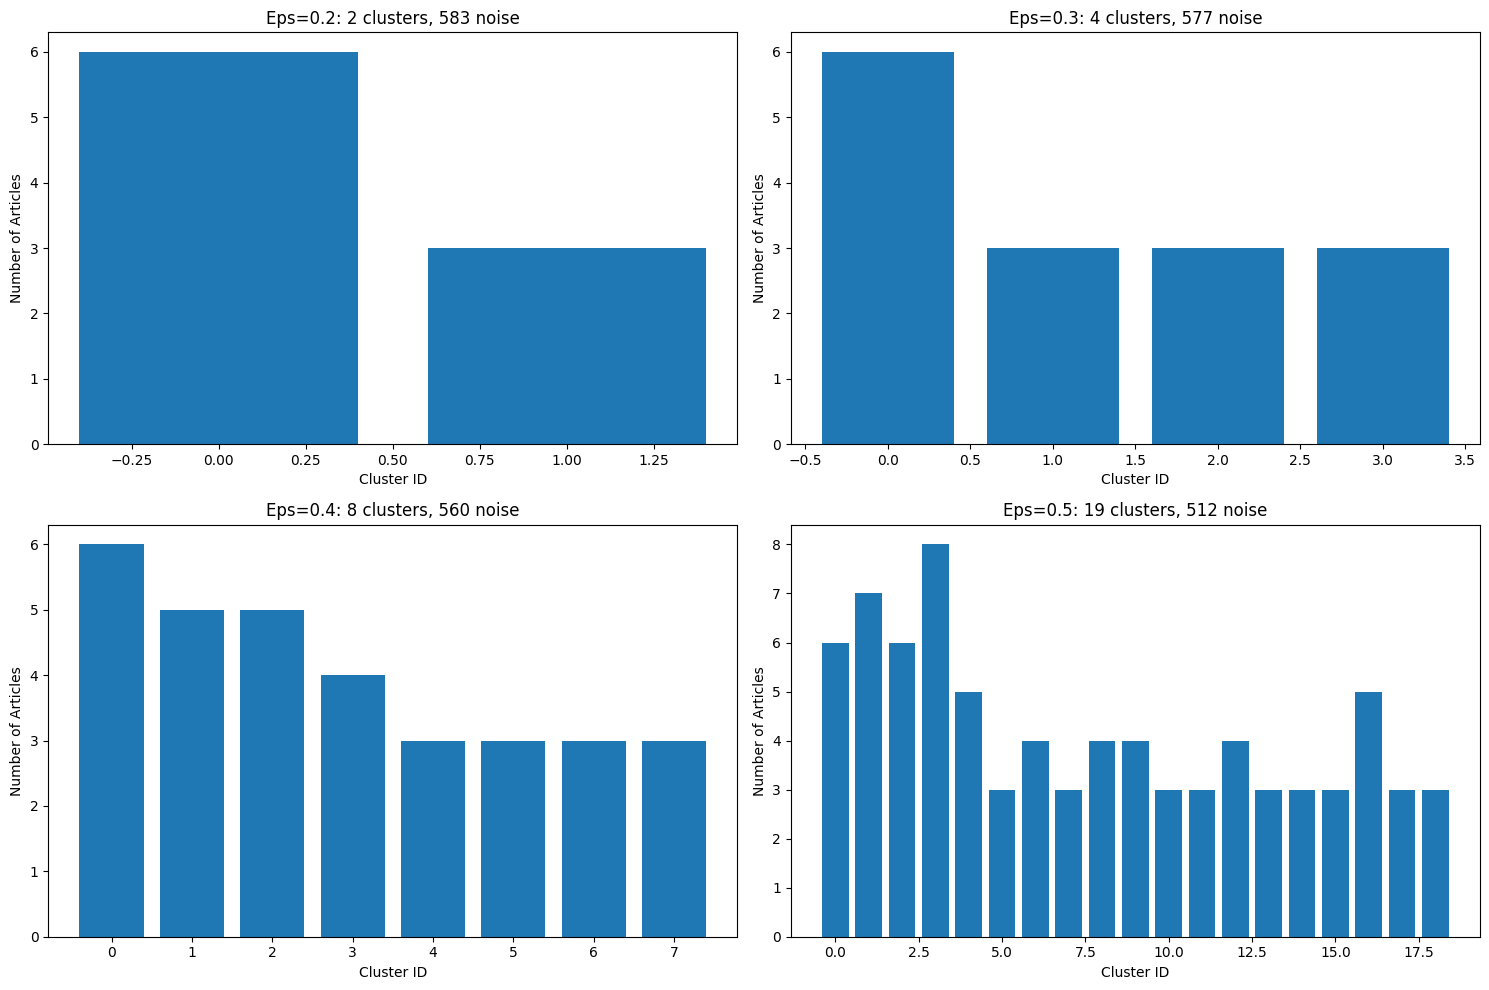

In [63]:
def visualize_clustering_results(clustering_results):
    """
    Visualize DBSCAN clustering results for different eps values.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (eps, (labels, cluster_df, cluster_counts)) in enumerate(clustering_results.items()):
        ax = axes[i]
        
        # Plot cluster sizes (excluding noise)
        valid_clusters = cluster_counts[cluster_counts.index != -1]
        
        if len(valid_clusters) > 0:
            ax.bar(range(len(valid_clusters)), valid_clusters.values)
            ax.set_title(f'Eps={eps}: {len(valid_clusters)} clusters, {cluster_counts.get(-1, 0)} noise')
            ax.set_xlabel('Cluster ID')
            ax.set_ylabel('Number of Articles')
        else:
            ax.text(0.5, 0.5, f'No clusters found\n(eps={eps})', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'Eps={eps}: No clusters')
    
    plt.tight_layout()
    plt.show()

visualize_clustering_results(clustering_results)

In [64]:
def examine_cluster_content(cluster_df, cluster_id, max_articles=5):
    """
    Examine the content of a specific cluster.
    """
    cluster_articles = cluster_df[cluster_df['cluster'] == cluster_id]
    
    print(f"\nCluster {cluster_id} ({len(cluster_articles)} articles):")
    print("Country distribution:", cluster_articles['country'].value_counts().to_dict())
    print("Source distribution:", cluster_articles['source'].value_counts().to_dict())
    print("Worldview distribution:", cluster_articles['worldview_score'].value_counts().to_dict())
    
    print(f"\nSample articles (showing up to {max_articles}):")
    for i, (idx, row) in enumerate(cluster_articles.head(max_articles).iterrows()):
        print(f"{i+1}. [{row['source']}] {row['headline']}")
        print(f"   Content: {row['content_clean'][:100]}...\n")

# Choose best eps value and examine clusters
best_eps = 0.3  # adjust based on your results
_, best_cluster_df, best_cluster_counts = clustering_results[best_eps]

# Show largest clusters
valid_clusters = best_cluster_counts[best_cluster_counts.index != -1]
largest_clusters = valid_clusters.nlargest(3)

for cluster_id in largest_clusters.index:
    examine_cluster_content(best_cluster_df, cluster_id)


Cluster 0 (6 articles):
Country distribution: {'sweden': 6}
Source distribution: {'dn': 6}
Worldview distribution: {2: 5, 4: 1}

Sample articles (showing up to 5):
1. [dn] Förslag: Slarv med a-kassan ska ge straffavgift
   Content: ...

2. [dn] Framgångsvåg för Demokraterna i hela USA
   Content: ...

3. [dn] EU vill korta tågresan Stockholm–Köpenhamn till fyra timmar
   Content: ...

4. [dn] Fosterskadande kemikalier i piratkopierade Labubus: ”Väldigt allvarligt”
   Content: ...

5. [dn] Myggsmitta sprider sig i Europa – fall i Berlin
   Content: ...


Cluster 1 (3 articles):
Country distribution: {'sweden': 3}
Source distribution: {'dn': 1, 'svd': 1, 'aftonbladet': 1}
Worldview distribution: {2: 3}

Sample articles (showing up to 5):
1. [dn] Akut säkerhetsmöte efter drönarlarmen i Belgien
   Content: Belgiens premiärminister Bart De Wever kallar till ett akut regeringsmöte efter de upprepade drönarl...

2. [svd] Akut säkerhetsmöte efter drönarlarmen i Belgien
   Content: Belgiens pr

### ***Locality Sensitive Hashing***

In [65]:
from datasketch import MinHashLSH, MinHash
import hashlib
import numpy as np

class EnhancedLSH:
    """
    LSH implementation with multiple hash families and analysis tools.
    """
    
    def __init__(self, threshold=0.5, num_perm=128, num_bands=None):
        self.threshold = threshold
        self.num_perm = num_perm
        self.num_bands = num_bands or max(1, num_perm // 8)
        self.lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
        self.minhashes = {}
        self.metadata = {}
        
    def add_document(self, doc_id, text, metadata=None):
        """
        Add a document to the LSH index.
        """
        shingles = get_shingles(text, k=5)
        minhash = create_minhash(shingles, self.num_perm)
        
        self.lsh.insert(str(doc_id), minhash)
        self.minhashes[doc_id] = minhash
        
        if metadata:
            self.metadata[doc_id] = metadata
    
    def query_similar(self, doc_id, return_scores=True):
        """
        Find similar documents to a given document.
        """
        if doc_id not in self.minhashes:
            return []
            
        query_hash = self.minhashes[doc_id]
        candidates = self.lsh.query(query_hash)
        
        results = []
        for candidate in candidates:
            candidate_id = int(candidate)
            if candidate_id == doc_id:
                continue
                
            if return_scores:
                similarity = query_hash.jaccard(self.minhashes[candidate_id])
                results.append((candidate_id, similarity))
            else:
                results.append(candidate_id)
        
        if return_scores:
            results.sort(key=lambda x: x[1], reverse=True)
            
        return results
    
    def get_all_similar_pairs(self):
        """
        Get all similar pairs found by LSH.
        """
        similar_pairs = set()
        
        for doc_id in self.minhashes:
            neighbors = self.query_similar(doc_id, return_scores=False)
            for neighbor_id in neighbors:
                pair = tuple(sorted((doc_id, neighbor_id)))
                similar_pairs.add(pair)
        
        return similar_pairs

# LSH index
enhanced_lsh = EnhancedLSH(threshold=0.4, num_perm=128)

for idx, row in news_articles.iterrows():
    metadata = {
        'country': row['country'],
        'source': row['source'],
        'worldview_score': row['worldview_score'],
        'headline': row['headline']
    }
    enhanced_lsh.add_document(idx, row['text'], metadata)

print(f"LSH index built with {len(enhanced_lsh.minhashes)} documents")

LSH index built with 592 documents


In [66]:
def analyze_lsh_performance(enhanced_lsh, news_df):
    """
    Analyze LSH performance and similarity patterns.
    """
    all_pairs = enhanced_lsh.get_all_similar_pairs()
    
    print(f"Total similar pairs found: {len(all_pairs)}")
    
    # Analyze similarity distribution
    similarities = []
    country_matches = 0
    source_matches = 0
    worldview_matches = 0
    
    for doc1, doc2 in all_pairs:
        sim = enhanced_lsh.minhashes[doc1].jaccard(enhanced_lsh.minhashes[doc2])
        similarities.append(sim)
        
        meta1 = enhanced_lsh.metadata[doc1]
        meta2 = enhanced_lsh.metadata[doc2]
        
        if meta1['country'] == meta2['country']:
            country_matches += 1
        if meta1['source'] == meta2['source']:
            source_matches += 1
        if meta1['worldview_score'] == meta2['worldview_score']:
            worldview_matches += 1
    
    if len(all_pairs) > 0:
        print(f"Average similarity: {np.mean(similarities):.3f}")
        print(f"Same country ratio: {country_matches / len(all_pairs):.3f}")
        print(f"Same source ratio: {source_matches / len(all_pairs):.3f}")
        print(f"Same worldview ratio: {worldview_matches / len(all_pairs):.3f}")
    
    return similarities, all_pairs

similarities, similar_pairs = analyze_lsh_performance(enhanced_lsh, news_articles)

# Show top similar pairs
pair_details = []
for doc1, doc2 in list(similar_pairs)[:10]:
    sim = enhanced_lsh.minhashes[doc1].jaccard(enhanced_lsh.minhashes[doc2])
    pair_details.append((sim, doc1, doc2))

pair_details.sort(reverse=True)

print("\nTop 5 most similar pairs:")
for sim, doc1, doc2 in pair_details[:5]:
    print(f"\nSimilarity: {sim:.3f} | Pair: {doc1} – {doc2}")
    print(f"A: [{news_articles.loc[doc1, 'source']}] {news_articles.loc[doc1, 'headline']}")
    print(f"B: [{news_articles.loc[doc2, 'source']}] {news_articles.loc[doc2, 'headline']}")

Total similar pairs found: 19
Average similarity: 0.423
Same country ratio: 1.000
Same source ratio: 0.632
Same worldview ratio: 0.789

Top 5 most similar pairs:

Similarity: 0.805 | Pair: 67 – 74
A: [dr] Ansøgninger fra Bangladesh og Nepal til uddannelser falder efter stramninger
B: [jyllands-posten] Ansøgninger fra Bangladesh og Nepal til uddannelser falder efter stramninger

Similarity: 0.500 | Pair: 173 – 189
A: [svd] Akut säkerhetsmöte efter drönarlarmen i Belgien
B: [aftonbladet] Akut säkerhetsmöte efter drönarlarmen i Belgien

Similarity: 0.391 | Pair: 16 – 147
A: [dn] Förslag: Slarv med a-kassan ska ge straffavgift
B: [dn] EU vill korta tågresan Stockholm–Köpenhamn till fyra timmar

Similarity: 0.352 | Pair: 183 – 474
A: [dn] Myggsmitta sprider sig i Europa – fall i Berlin
B: [dn] EU-länder har gjort upp om klimatmål till 2040

Similarity: 0.352 | Pair: 16 – 141
A: [dn] Förslag: Slarv med a-kassan ska ge straffavgift
B: [dn] Framgångsvåg för Demokraterna i hela USA


In [67]:
def compare_lsh_thresholds(thresholds, news_df):
    """
    Compare LSH performance across different similarity thresholds.
    """
    results_summary = []
    
    for threshold in thresholds:
        lsh_test = EnhancedLSH(threshold=threshold, num_perm=128)
        
        for idx, row in news_df.iterrows():
            metadata = {
                'country': row['country'],
                'source': row['source'],
                'worldview_score': row['worldview_score']
            }
            lsh_test.add_document(idx, row['text'], metadata)
        
        pairs = lsh_test.get_all_similar_pairs()
        
        if len(pairs) > 0:
            sims, _ = analyze_lsh_performance(lsh_test, news_df)
            avg_sim = np.mean(sims)
        else:
            avg_sim = 0
        
        results_summary.append({
            'threshold': threshold,
            'n_pairs': len(pairs),
            'avg_similarity': avg_sim
        })
        
        print(f"Threshold {threshold}: {len(pairs)} pairs, avg similarity: {avg_sim:.3f}")
    
    return pd.DataFrame(results_summary)

# Test different thresholds
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = compare_lsh_thresholds(thresholds, news_articles)

display(HTML("<h4>LSH Threshold Comparison</h4>"))
display(HTML(threshold_results.to_html(index=False)))

Total similar pairs found: 145
Average similarity: 0.166
Same country ratio: 1.000
Same source ratio: 0.917
Same worldview ratio: 0.676
Threshold 0.2: 145 pairs, avg similarity: 0.166
Total similar pairs found: 31
Average similarity: 0.360
Same country ratio: 1.000
Same source ratio: 0.742
Same worldview ratio: 0.710
Threshold 0.3: 31 pairs, avg similarity: 0.360
Total similar pairs found: 19
Average similarity: 0.423
Same country ratio: 1.000
Same source ratio: 0.632
Same worldview ratio: 0.789
Threshold 0.4: 19 pairs, avg similarity: 0.423
Total similar pairs found: 7
Average similarity: 0.564
Same country ratio: 1.000
Same source ratio: 0.286
Same worldview ratio: 0.857
Threshold 0.5: 7 pairs, avg similarity: 0.564
Total similar pairs found: 2
Average similarity: 0.902
Same country ratio: 1.000
Same source ratio: 0.000
Same worldview ratio: 1.000
Threshold 0.6: 2 pairs, avg similarity: 0.902
Total similar pairs found: 2
Average similarity: 0.902
Same country ratio: 1.000
Same source

threshold,n_pairs,avg_similarity
0.2,145,0.166325
0.3,31,0.359627
0.4,19,0.422697
0.5,7,0.563616
0.6,2,0.902344
0.7,2,0.902344


#### LSH vs ANN Comparison

In [68]:
def compare_ann_vs_lsh(query_idx, ann_index, enhanced_lsh, matrix, news_df, n_neighbors=10):
    """
    Compare ANN and LSH results for a specific query article.
    """
    # ANN results
    ann_indices, ann_distances = find_similar_articles(query_idx, ann_index, matrix, n_neighbors)
    ann_similarities = 1 - ann_distances
    
    # LSH results
    lsh_results = enhanced_lsh.query_similar(query_idx, return_scores=True)
    lsh_indices = [idx for idx, _ in lsh_results]
    lsh_similarities = [sim for _, sim in lsh_results]
    
    print(f"Query article {query_idx}: '{news_df.loc[query_idx, 'headline']}'")
    print(f"Country: {news_df.loc[query_idx, 'country']} | Source: {news_df.loc[query_idx, 'source']}\n")
    
    print(f"ANN found {len(ann_indices)} neighbors")
    print(f"LSH found {len(lsh_indices)} neighbors\n")
    
    # Show overlap
    ann_set = set(ann_indices)
    lsh_set = set(lsh_indices)
    overlap = ann_set.intersection(lsh_set)
    
    print(f"Overlap: {len(overlap)} articles")
    print(f"ANN-only: {len(ann_set - lsh_set)} articles")
    print(f"LSH-only: {len(lsh_set - ann_set)} articles\n")
    
    # top 3 results
    print("Top 3 ANN results:")
    for i, (idx, sim) in enumerate(zip(ann_indices[:3], ann_similarities[:3])):
        print(f"  {i+1}. Sim: {sim:.3f} | [{news_df.loc[idx, 'source']}] {news_df.loc[idx, 'headline']}")
    
    print("\nTop 3 LSH results:")
    for i, (idx, sim) in enumerate(lsh_results[:3]):
        print(f"  {i+1}. Sim: {sim:.3f} | [{news_df.loc[idx, 'source']}] {news_df.loc[idx, 'headline']}")

# compare with sampled articles
sample_articles = [0, 50, 100, 200, 300]

for article_idx in sample_articles:
    print("=" * 80)
    compare_ann_vs_lsh(article_idx, ann_index, enhanced_lsh, tfidf_matrix, news_articles, n_neighbors=5)
    print()

Query article 0: 'Skakande orden i rätten: ”Rann blod i mina ögon”'
Country: sweden | Source: aftonbladet

ANN found 10 neighbors
LSH found 0 neighbors

Overlap: 0 articles
ANN-only: 10 articles
LSH-only: 0 articles

Top 3 ANN results:
  1. Sim: 0.265 | [aftonbladet] Så får du bäst resultat med fetmaläkemedlen
  2. Sim: 0.193 | [aftonbladet] Handlarna som tjänar mest – fick ut 22 miljoner
  3. Sim: 0.149 | [aftonbladet] Varg dödade tre alpackor

Top 3 LSH results:

Query article 50: 'Her er de liberales løfte til københavnerne: Vil smadre kommunens kæmpe sparegris og bruge pengene på store skattelettelser'
Country: denmark | Source: berlingske

ANN found 10 neighbors
LSH found 0 neighbors

Overlap: 0 articles
ANN-only: 10 articles
LSH-only: 0 articles

Top 3 ANN results:
  1. Sim: 0.168 | [berlingske] Nedskrivninger trækker Ørsted-regnskab i minus
  2. Sim: 0.160 | [berlingske] Måling giver »gigantisk mavepuster« til Socialdemokratiet: Rosenkrantz-Theil har »brug for et mirakel«
  3. S